In [69]:
import pandas as pd
import geopandas as gpd
import matplotlib.pyplot as plt
import shapely
import difflib # string differences
import numpy as np
import matplotlib

%matplotlib inline

In [71]:
print(shapely.__version__)
print(np.__version__)
print(matplotlib.__version__)
print(gpd.__version__)
print(pd.__version__)


1.6.4.post2
1.16.2
3.0.3
0.4.0+26.g9e584cc
0.24.2


In [2]:
air_pollution_rates = pd.read_csv("preprocessed_data/death-rates-from-ambient-particulate-air-pollution.csv")
air_pollution_exposure = pd.read_csv("preprocessed_data/PM25-air-pollution.csv")
countries = gpd.read_file("../../assets/data/countries.geo.json")


In [3]:
air_pollution_rates.head()

,Entity,Code,Year,"Deaths - Ambient particulate matter pollution - Sex: Both - Age: Age-standardized (Rate) (deaths per 100,000)"
0,Afghanistan,AFG,1990,46.446589
1,Afghanistan,AFG,1991,46.033841
2,Afghanistan,AFG,1992,44.243766
3,Afghanistan,AFG,1993,44.440148
4,Afghanistan,AFG,1994,45.594328


In [4]:
air_pollution_exposure.head()

,Entity,Code,Year,"PM2.5 air pollution, mean annual exposure (micrograms per cubic meter) (micrograms per cubic meter)"
0,Afghanistan,AFG,1990,60.936690
1,Afghanistan,AFG,1995,56.136628
2,Afghanistan,AFG,2000,56.092028
3,Afghanistan,AFG,2005,43.234032
4,Afghanistan,AFG,2010,46.536809


In [5]:
### INITIAL SUBSETTING
air_pollution_rates = air_pollution_rates[air_pollution_rates.Year.apply(lambda yr: int(yr) >= 1990)].reset_index(drop=True)
air_pollution_rates.columns = ["country", "code","year", "deaths_per100000"]
# air_pollution_rates.to_csv("preprocessed_data/death-rates-from-ambient-particulate-air-pollution.csv",index=False)

air_pollution_exposure = air_pollution_exposure[air_pollution_exposure.Year.apply(lambda yr: int(yr) >= 1990)].reset_index(drop=True)
air_pollution_exposure.columns = ["country", "code","year", "pm25_exposure"]
# air_pollution_exposure.to_csv("preprocessed_data/PM25-air-pollution.csv",index=False)

In [6]:
air_pollution = air_pollution_rates.merge(air_pollution_exposure, how='left')

In [7]:
air_pollution.head()

,country,code,year,deaths_per100000,pm25_exposure
0,Afghanistan,AFG,1990,46.446589,60.93669
1,Afghanistan,AFG,1991,46.033841,NaN
2,Afghanistan,AFG,1992,44.243766,NaN
3,Afghanistan,AFG,1993,44.440148,NaN
4,Afghanistan,AFG,1994,45.594328,NaN


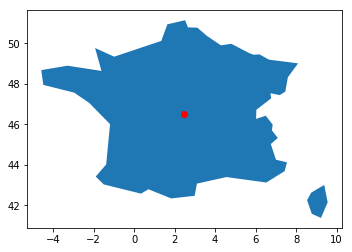

In [8]:
## Plotting a centroid
fig, ax = plt.subplots(1)
countries[countries.name == "France"].plot(ax=ax)
countries[countries.name == "France"].centroid.plot(color='red', ax=ax)

In [9]:
countries['centroid'] = countries.geometry.apply(lambda cn: cn.centroid)

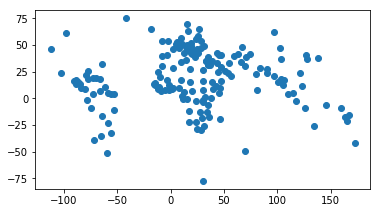

In [10]:
countries.centroid.plot()

In [11]:
## make a set of the countries to look at differences
airpol_countries = set(air_pollution.country.unique())
cn_countries = set(countries.name.unique())

cn_countries_diff = cn_countries.difference(airpol_countries)
airpol_diff = airpol_countries.difference(cn_countries)

print(cn_countries_diff)
print(airpol_diff)

{'Western Sahara', 'Democratic Republic of the Congo', 'New Caledonia', 'The Bahamas', 'Somaliland', 'Northern Cyprus', 'Falkland Islands', 'Republic of Serbia', 'Republic of the Congo', 'French Southern and Antarctic Lands', 'United States of America', 'Guinea Bissau', 'East Timor', 'Kosovo', 'Ivory Coast', 'West Bank', 'French Guiana', 'United Republic of Tanzania', 'Antarctica'}
{'Northern Mariana Islands', 'Southern Latin America', 'Central Europe', 'Guinea-Bissau', 'Low-middle SDI', 'Micronesia (country)', 'Caribbean', 'Australasia', 'Seychelles', 'Guam', 'Mauritius', 'Central Latin America', "Cote d'Ivoire", 'Tropical Latin America', 'Sub-Saharan Africa', 'Eastern Europe', 'Scotland', 'Southern Sub-Saharan Africa', 'United States', 'Antigua and Barbuda', 'High-income', 'Middle SDI', 'American Samoa', 'Tanzania', 'Andean Latin America', 'Kiribati', 'Comoros', 'East Asia', 'High SDI', 'Democratic Republic of Congo', 'North America', 'United States Virgin Islands', 'Oceania', 'Grena

In [12]:
## LOOK at country names from each dataset which are similar in string distance
to_change = {}
for airpoldiff in airpol_diff:
    for cndiff in cn_countries_diff:
        try:
            the_ratio = difflib.SequenceMatcher(None, cndiff, airpoldiff).ratio()
            if the_ratio > 0.7:
                print("'%s' should be changed to '%s'. Similarity score = %s" % (airpoldiff, cndiff, round(the_ratio, 3)))
                to_change["{}".format(cndiff)] = airpoldiff
        except:
            pass

'Guinea-Bissau' should be changed to 'Guinea Bissau'. Similarity score = 0.923
'United States' should be changed to 'United States of America'. Similarity score = 0.703
'Democratic Republic of Congo' should be changed to 'Democratic Republic of the Congo'. Similarity score = 0.933
'Bahamas' should be changed to 'The Bahamas'. Similarity score = 0.778


In [13]:
## user prompt to change country nanes
for chng in to_change.items():
    change = input("Do you want to change %s to %s" % (chng[0], chng[1]))
    if change.lower() == "y":
        countries.replace(chng[0], chng[1], inplace=True)
        print("ITEM CHANGED")
    else:
        print("item not changed")

## DO NOT CHANGE FALKLAND ISLANDS

Do you want to change Guinea Bissau to Guinea-Bissauy
ITEM CHANGED
Do you want to change United States of America to United Statesy
ITEM CHANGED
Do you want to change Democratic Republic of the Congo to Democratic Republic of Congoy
ITEM CHANGED
Do you want to change The Bahamas to Bahamasy
ITEM CHANGED


In [14]:
## NOTES:
## ADD back Hong Kong and Singapore (manually get centroid)
## Singapore 1.290270, 103.851959.
## Hong Kong 22.3193° N, 114.1694° E

In [15]:
## merge air pollution
air_pollution = air_pollution.merge(countries, left_on="country", right_on="name",how="left")
## then drop uneeded columns
air_pollution.drop(['geometry'], axis=1, inplace=True)
air_pollution.rename(index=str, columns={"centroid": "geometry"},inplace=True)

In [16]:
air_pollution.dropna(subset=['geometry'],inplace=True)
air_pollution.reset_index(drop=True, inplace=True)

In [17]:
air_pollution_rates_gdf = gpd.GeoDataFrame(air_pollution, geometry="geometry")

In [18]:
for ind in air_pollution_rates_gdf.iloc[np.where(air_pollution_rates_gdf.country == "Singapore")].index:
    air_pollution_rates.at[ind,'geometry'] = shapely.geometry.Point(103.851959, 1.290270)
for ind in air_pollution_rates_gdf.iloc[np.where(air_pollution_rates_gdf.country == "Hong Kong")].index:
    air_pollution_rates.at[ind,'geometry'] = shapely.geometry.Point(114.1694, 22.3193)

In [19]:
air_pollution_rates_gdf.country.value_counts()

Namibia                         28
Lebanon                         28
Switzerland                     28
Uruguay                         28
Costa Rica                      28
Saudi Arabia                    28
Swaziland                       28
Armenia                         28
Hungary                         28
Estonia                         28
United Arab Emirates            28
Djibouti                        28
Democratic Republic of Congo    28
Israel                          28
Central African Republic        28
Liberia                         28
Russia                          28
Kyrgyzstan                      28
Lithuania                       28
Ukraine                         28
Macedonia                       28
New Zealand                     28
Sierra Leone                    28
Malawi                          28
Guinea-Bissau                   28
Honduras                        28
Togo                            28
Gabon                           28
Bahamas             

In [20]:
air_pollution_rates_gdf

,country,code,year,deaths_per100000,pm25_exposure,id,name,geometry
0,Afghanistan,AFG,1990,46.446589,60.936690,AFG,Afghanistan,POINT (66.08669017344639 33.85639924331851)
1,Afghanistan,AFG,1991,46.033841,NaN,AFG,Afghanistan,POINT (66.08669017344639 33.85639924331851)
2,Afghanistan,AFG,1992,44.243766,NaN,AFG,Afghanistan,POINT (66.08669017344639 33.85639924331851)
3,Afghanistan,AFG,1993,44.440148,NaN,AFG,Afghanistan,POINT (66.08669017344639 33.85639924331851)
4,Afghanistan,AFG,1994,45.594328,NaN,AFG,Afghanistan,POINT (66.08669017344639 33.85639924331851)
5,Afghanistan,AFG,1995,45.367141,56.136628,AFG,Afghanistan,POINT (66.08669017344639 33.85639924331851)
6,Afghanistan,AFG,1996,45.383591,NaN,AFG,Afghanistan,POINT (66.08669017344639 33.85639924331851)
7,Afghanistan,AFG,1997,45.585062,NaN,AFG,Afghanistan,POINT (66.08669017344639 33.85639924331851)
8,Afghanistan,AFG,1998,44.837490,NaN,AFG,Afghanistan,POINT (66.08669017344639 33.85639924331851)
9,Afghanistan,AFG,1999,45.325501,NaN,AFG,Afghanistan,POINT (66.08669017344639 33.85639924331851)


In [21]:
air_pollution_rates_gdf.to_file("../../assets/data/airpollutionDeaths.geojson", driver="GeoJSON")

In [ ]:
## create histogram plot

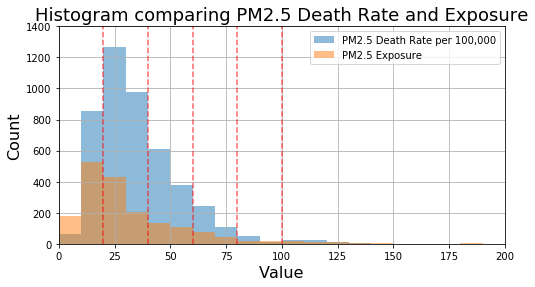

In [64]:
plt.rcParams['figure.figsize'] = (8,4)
air_pollution_rates_gdf.deaths_per100000.hist(bins=np.arange(0,200,10), alpha=.5)
air_pollution_rates_gdf.pm25_exposure.hist(bins=np.arange(0,200,10), alpha=.5)
plt.legend(["PM2.5 Death Rate per 100,000", "PM2.5 Exposure"])
plt.ylabel("Count", size=16)
plt.xlabel("Value", size=16)
for xval in [20,40,60,80,100]:
    plt.vlines(x=xval,ymin=0, ymax=1400, colors='red', linestyles='--', alpha=.6)
plt.xlim(0,200)
plt.ylim(0,1400)
plt.title("Histogram comparing PM2.5 Death Rate and Exposure", size=18)
plt.savefig("../../assets/img/histogram_pm25.png", bbox_inches='tight')